# imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, GridSearchCV
from sklearn.base import clone
import matplotlib.pyplot as plt

# General precofniguration

## load data

In [2]:
df_budget = pd.read_csv("budget.csv")
df_contract = pd.read_csv("contract.csv")
df_budget.head()

,district,specialty,points,status
0,м. Київ,191,181.500,1
1,м. Київ,181,170.000,1
2,м. Київ,131,182.172,1
3,м. Київ,61,186.125,1
4,м. Київ,101,173.655,1


In [3]:
df_contract.head()

,district,specialty,points,status
0,м. Київ,191,181.500,1
1,м. Київ,181,170.000,1
2,м. Київ,131,182.172,1
3,м. Київ,61,186.125,1
4,м. Київ,101,173.655,1


## Prepare data for learning
X - because data are the same for both cases

y_b - labels where we prefer budget applicants

y_c - labels where we prefer contract applicants

In [4]:
def separate_results_from_data(df, budget=True):
    data = df.sample(30000, random_state=2).values
    X, y = data[:, :-1], data[:, -1:]
    y = y.astype("int")
    y = y.ravel()
    return X, y


X, y_b = separate_results_from_data(df_budget)
_, y_c = separate_results_from_data(df_contract)

In [5]:
def get_train_test_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)
    y_train = y_train
    y_test = y_test
    return X_train, X_test, y_train, y_test


X_train, X_test, y_b_train, y_b_test = get_train_test_split(X, y_b)
_, _, y_c_train, y_c_test = get_train_test_split(X, y_c)

In [6]:
np.unique(X[:, 0])

array(['Івано-Франківська область', 'Волинська область',
       'Вінницька область', 'Дніпропетровська область',
       'Донецька область', 'Житомирська область', 'Закарпатська область',
       'Запорізька область', 'Київська область', 'Кіровоградська область',
       'Луганська область', 'Львівська область', 'Миколаївська область',
       'Одеська область', 'Полтавська область', 'Рівненська область',
       'Сумська область', 'Тернопільська область', 'Харківська область',
       'Херсонська область', 'Хмельницька область', 'Черкаська область',
       'Чернівецька область', 'Чернігівська область', 'м. Київ'],
      dtype=object)

## Greed search
For logistic regression, results ~ 79%
 - PCA - n_components: 139, so no PCA
 - C: 10
 - max_iter: 7
 - penalty: l1

For SVC, results ~ 82%
 - C: 100
 - gamma: auto

In [7]:
pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("ohe0", OneHotEncoder(categories=[np.unique(X[:, 0]), np.unique(X[:, 1])], sparse=False), [0, 1]),
        ],
        remainder="passthrough",
        n_jobs=-1
    ),
    StandardScaler(),
    LogisticRegression(
        C=10,
        max_iter=7,
        penalty="l1",
    )
)

In [8]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X_train,
    y=y_b_train,
    train_sizes=np.linspace(0.1, 1, 10),
    cv=5,
    n_jobs=4
)

/home/dima/data/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


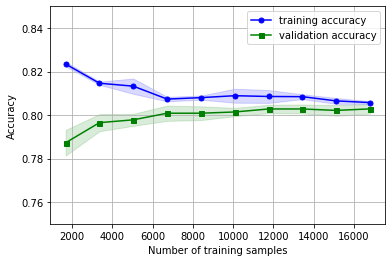

In [9]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color="blue", marker="o", markersize=5, label="training accuracy")
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color="blue")
plt.plot(train_sizes, test_mean, color="green", marker="s", markersize=5, label="validation accuracy")
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color="green")
plt.grid()
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.ylim([0.75, .85])
plt.legend()
plt.show()

# Learn models

## Check on test samples

In [10]:
pipe_budget_test = clone(pipeline)
pipe_contract_test = clone(pipeline)
pipe_budget_test.fit(X_train, y_b_train)
pipe_contract_test.fit(X_train, y_c_train)

/home/dima/data/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dima/data/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/dima/data/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dima/data/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe0',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=[array(['Івано-Франківська область', 'Волинська область',
       'Вінницька область', 'Дніпропетровська область',
       'Донецька область', 'Житомирська о...
                                   verbose=False)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                

In [11]:
pipe_budget_test.score(X_test, y_b_test)

0.7942222222222223

In [12]:
pipe_contract_test.score(X_test, y_c_test)

0.937

## Final learning

In [13]:
pipe_budget = clone(pipeline)
pipe_contract = clone(pipeline)
pipe_budget.fit(X, y_b)
pipe_contract.fit(X, y_c)

/home/dima/data/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dima/data/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/dima/data/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dima/data/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe0',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=[array(['Івано-Франківська область', 'Волинська область',
       'Вінницька область', 'Дніпропетровська область',
       'Донецька область', 'Житомирська о...
                                   verbose=False)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                

In [14]:
df = pd.DataFrame([["м. Київ", 141, 160]])
pipe_budget.predict_proba(df.values)

array([[0.10091807, 0.89908193]])

In [15]:
pipe_contract.predict_proba(df.values)

array([[0.04332109, 0.95667891]])

In [16]:
from joblib import dump
dump(pipe_budget, "budget_after_greed_search.joblib")
dump(pipe_contract, "contract_after_greed_search.joblib")

['contract_after_greed_search.joblib']